# Introduction
State notebook purpose here

### Imports

First of all, we will run the basic data processing notebook before starting text cleaning

In [3]:
%run "[Rahul Sharma]-[Shreyesh Doppalapudi]-[Shivang Suchak]-Basic-Exploration-Script.ipynb"

<Figure size 1400x900 with 1 Axes>

In [42]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import nltk
import scipy
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import matplotlib
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

## Preprocess Product Reviews Text

### Positive Label

In [4]:
final_product_reviews["positivity"] = reviews["rating"].apply(lambda x: 1 if x>3 else(0 if x==3 else -1))

### Clean Text Function

In [5]:
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
keywords = product_reviews["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
lemma = WordNetLemmatizer()

In [6]:
def clean_text(text):
    # Convert the text into lowercase
    text = text.lower()
    # Split into list
    wordList = word_tokenize(text)
    # Remove punctuation
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    # Remove stopwords
    wordList = [word for word in wordList if word not in stop]
    # Remove other keywords
    wordList = [word for word in wordList if word not in keywords]
    # Lemmatisation
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)

### Apply the function to the Product Reviews Body

In [7]:
# final_product_reviews["body"] = final_product_reviews["body"].astype("str")
# final_product_reviews["clean_text"] = final_product_reviews["body"].apply(clean_text)

In [8]:
from nltk.tokenize import word_tokenize
import string
from collections import Counter
import re
from nltk.tag import pos_tag
import time
start_time=time.time()

stop = set(stopwords.words('english'))
punc = set(string.punctuation)
keywords = product_reviews["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
keywords.append("would")
keywords.append("could")

def pre_process(review):  
    y=word_tokenize(review['body'])
    tags=pos_tag(y)
    new_tags=list(filter(lambda tag:tag[0].lower().rstrip() not in punc and tag[0].lower().rstrip() not in stop and tag[0].lower().rstrip() not in keywords and not re.match('\w+\'\w+',tag[0]) and not re.match('\W+',tag[0]),tags))
    x=list(map(get_clean_token,new_tags))
    return " ".join(x)

def get_clean_token(tag):
    if tag[1].startswith("NN"):
        pos_updt = 'n'
    elif tag[1].startswith('VB'):
        pos_updt = 'v'
    else:
        pos_updt = 'a'
    lemmatizer=WordNetLemmatizer()
    root=lemmatizer.lemmatize(tag[0].lower().rstrip(),pos=pos_updt)
    return root

In [9]:
final_product_reviews["body"] = final_product_reviews["body"].astype("str")
final_product_reviews["clean_text"] = final_product_reviews.apply(pre_process,axis=1)

### Word Cloud

In [10]:
def word_freq_dict(text):
    # Convert text into word list
    wordList = text.split()
    # Generate word freq dictionary
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    return wordFreqDict

In [11]:
motorola = final_product_reviews[final_product_reviews["brand"]=="Motorola"].sort_values(by=["date"], ascending=False)
samsung = final_product_reviews[final_product_reviews["brand"]=="Samsung"].sort_values(by=["date"], ascending=False)
nokia = final_product_reviews[final_product_reviews["brand"]=="Nokia"].sort_values(by=["date"], ascending=False)

#### Define a function to create a wordcloud from dictionary of word frequency

In [12]:
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(15, 9)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

#### Define a function to plot top10 positive words and top10 negative words in a grouped bar plot

In [13]:
def topn_wordfreq_bar_both(pos_word_freq_dict, neg_word_freq_dict, pos_num_doc, neg_num_doc, topn, title, palette, height=6, aspect=2):
    # Transform positive word frequency into DF
    df_pos = pd.DataFrame.from_dict(pos_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_pos.columns = ["frequency"]
    df_pos["frequency"] = df_pos["frequency"] / pos_num_doc
    df_pos["label"] = "Positive"
    # Transform negative word frequency into DF
    df_neg = pd.DataFrame.from_dict(neg_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_neg.columns = ["frequency"]
    df_neg["frequency"] = df_neg["frequency"] / neg_num_doc
    df_neg["label"] = "Negative"
    # Append two dataframes
    df_append = df_pos.append(df_neg)
    df_append.reset_index(inplace=True)
    # Plot
    sns.catplot(x="index", y="frequency", hue="label", data=df_append, 
                kind="bar",
                palette=palette,
                height=height, aspect=aspect, 
                legend_out=False)
    plt.title(title)
    plt.show()

### Motorola

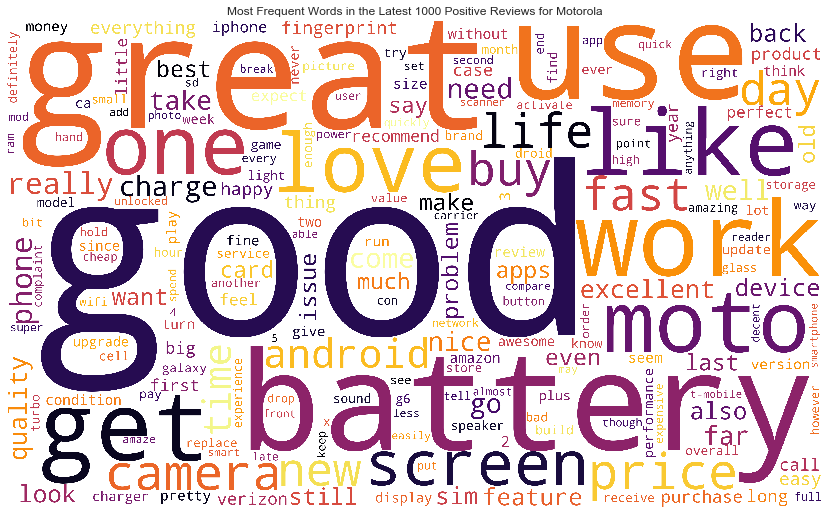

In [14]:
# Wordclouds for Positive reviews for Motorola
motorola_pos = " ".join(motorola[motorola["positivity"]==1]["clean_text"][0:1000])
motorola_pos_word_freq = word_freq_dict(motorola_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap=matplotlib.cm.inferno,
                      background_color="white")
wordcloud_from_frequency(motorola_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Motorola")

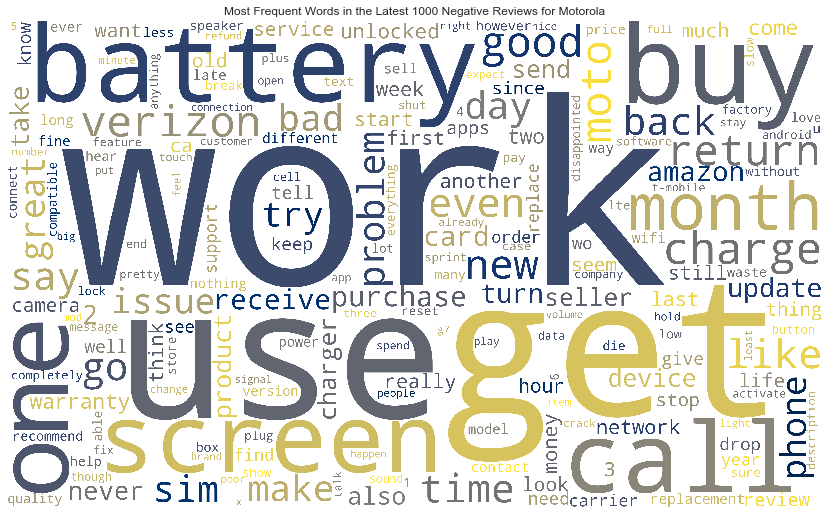

In [15]:
# Wordclouds for Negative reviews for Motorola
motorola_neg = " ".join(motorola[motorola["positivity"]==-1]["clean_text"][0:1000])
motorola_neg_word_freq = word_freq_dict(motorola_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap=matplotlib.cm.cividis,
                      background_color="white")
wordcloud_from_frequency(motorola_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Motorola")

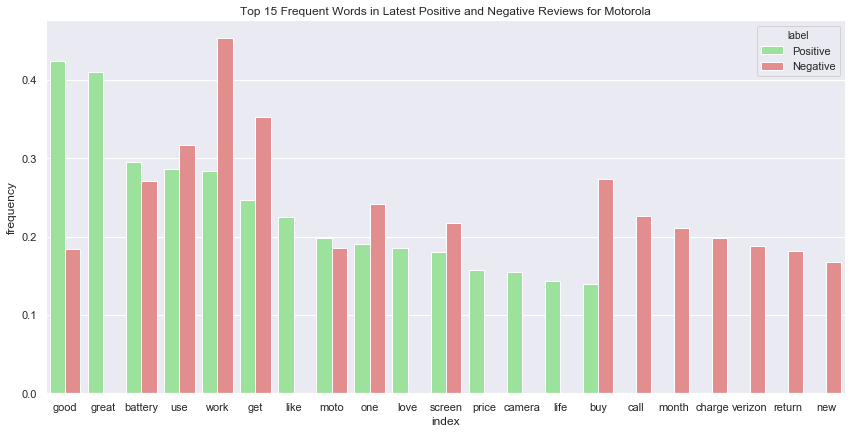

In [16]:
topn_wordfreq_bar_both(motorola_pos_word_freq, motorola_neg_word_freq, 
                       min(sum(motorola["positivity"]==1), 1000), 
                       min(sum(motorola["positivity"]==-1), 1000), 
                       15, 
                       "Top 15 Frequent Words in Latest Positive and Negative Reviews for Motorola", 
                       ['lightgreen', 'lightcoral'], 
                       height=6, aspect=2)

### Samsung

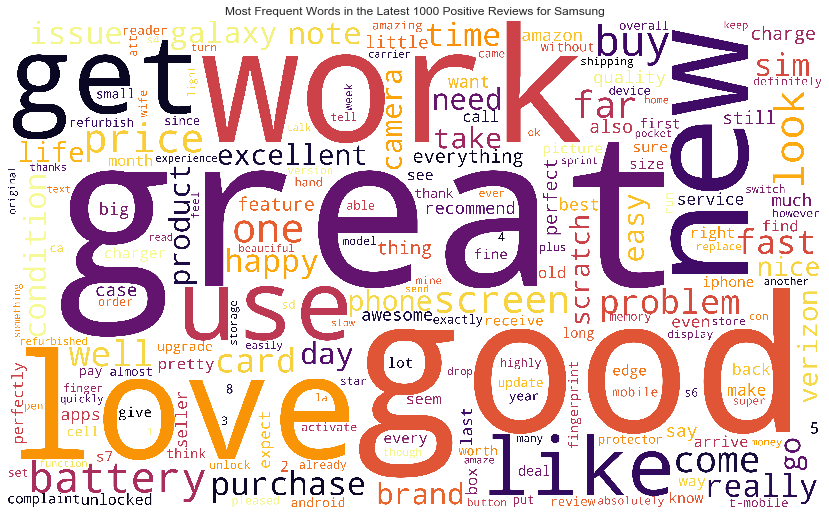

In [17]:
# Wordclouds for Positive reviews for Samsung
samsung_pos = " ".join(samsung[samsung["positivity"]==1]["clean_text"][0:1000])
samsung_pos_word_freq = word_freq_dict(samsung_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap=matplotlib.cm.inferno,
                      background_color="white")
wordcloud_from_frequency(samsung_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Samsung")

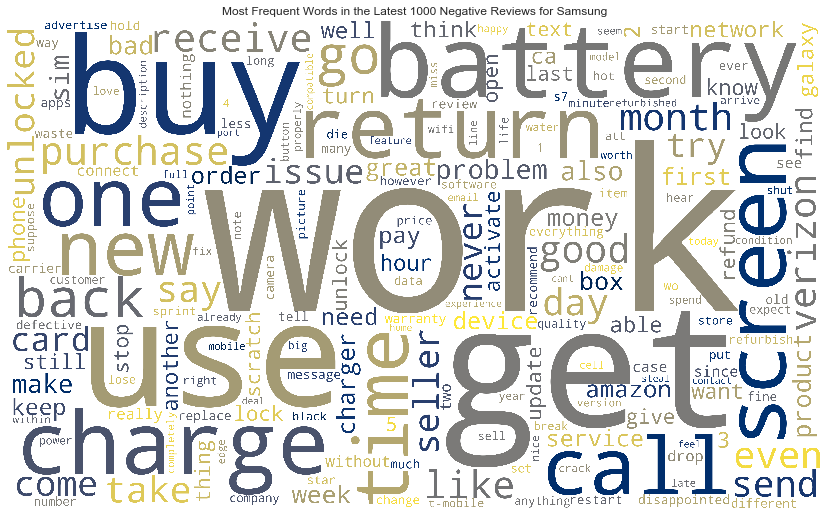

In [18]:
# Wordclouds for Positive reviews for Samsung
samsung_neg = " ".join(samsung[samsung["positivity"]==-1]["clean_text"][0:1000])
samsung_neg_word_freq = word_freq_dict(samsung_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap=matplotlib.cm.cividis,
                      background_color="white")
wordcloud_from_frequency(samsung_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Samsung")

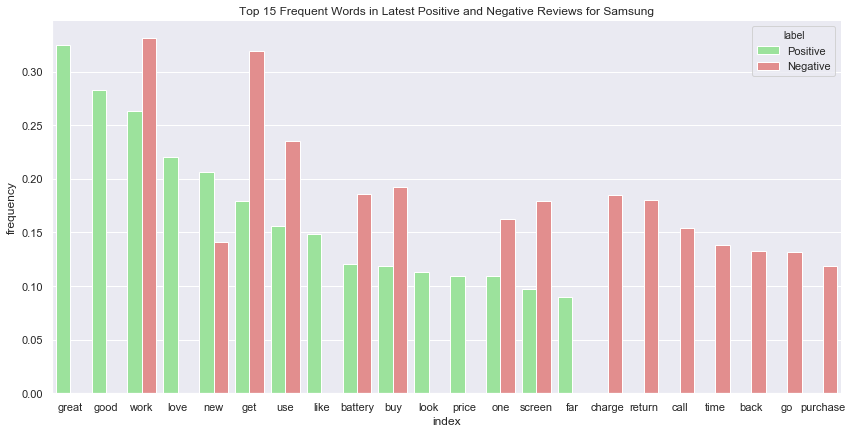

In [19]:
topn_wordfreq_bar_both(samsung_pos_word_freq, samsung_neg_word_freq, 
                       min(sum(samsung["positivity"]==1), 1000), 
                       min(sum(samsung["positivity"]==-1), 1000), 
                       15, 
                       "Top 15 Frequent Words in Latest Positive and Negative Reviews for Samsung", 
                       ['lightgreen', 'lightcoral'], 
                       height=6, aspect=2)

### Nokia

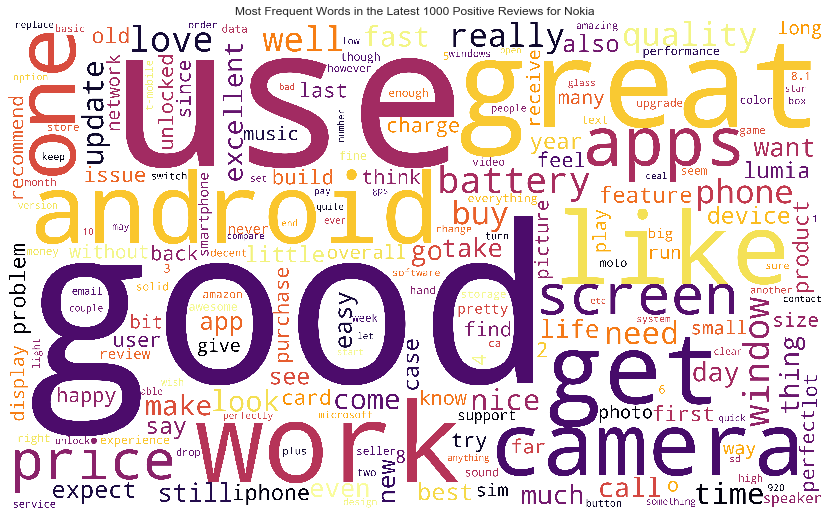

In [20]:
# Wordclouds for Positive reviews for Nokia
nokia_pos = " ".join(nokia[nokia["positivity"]==1]["clean_text"][0:1000])
nokia_pos_word_freq = word_freq_dict(nokia_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap=matplotlib.cm.inferno,
                      background_color="white")
wordcloud_from_frequency(nokia_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Nokia")

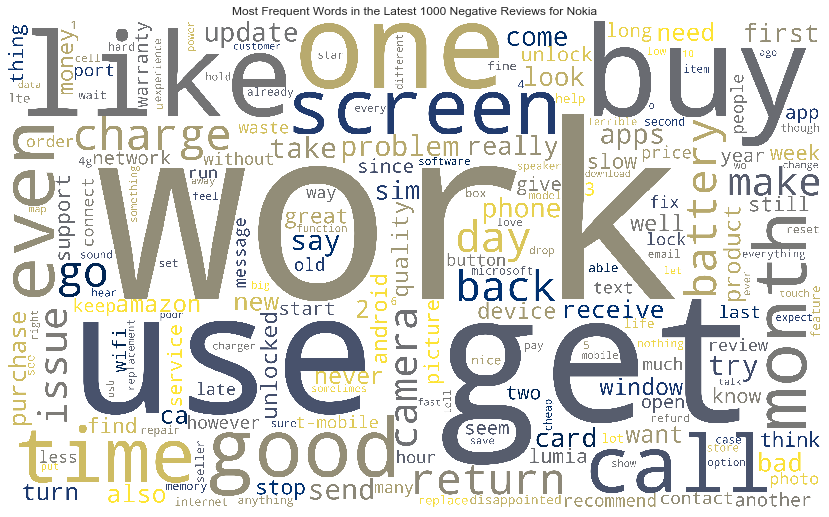

In [21]:
# Wordclouds for Positive reviews for Nokia
nokia_neg = " ".join(nokia[nokia["positivity"]==-1]["clean_text"][0:1000])
nokia_neg_word_freq = word_freq_dict(nokia_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap=matplotlib.cm.cividis,
                      background_color="white")
wordcloud_from_frequency(nokia_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Nokia")

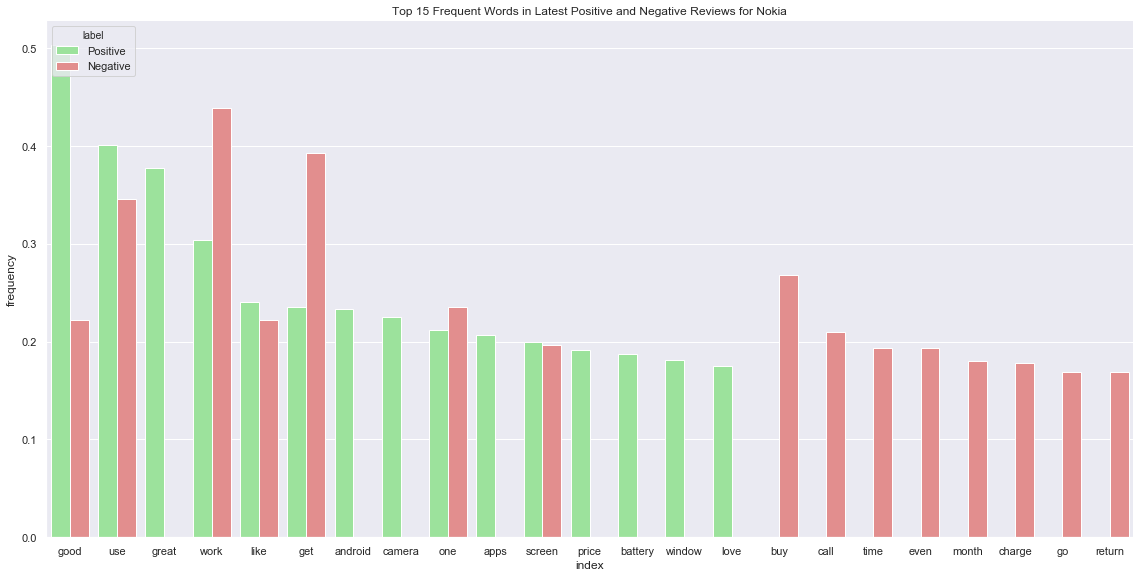

In [22]:
topn_wordfreq_bar_both(nokia_pos_word_freq, nokia_neg_word_freq, 
                       min(sum(nokia["positivity"]==1), 1000), 
                       min(sum(nokia["positivity"]==-1), 1000), 
                       15, 
                       "Top 15 Frequent Words in Latest Positive and Negative Reviews for Nokia", 
                       ['lightgreen', 'lightcoral'], 
                       height=8, aspect=2)

## Modelling

### Topic Modeling

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")

#### Initializing NMF Model

In [24]:
from sklearn.decomposition import NMF
n_topics=10
nmf = NMF(n_components=n_topics, max_iter=50, random_state=0, alpha=.1, l1_ratio=.5, init='nndsvd')

#### Function to Display Topics

In [25]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### Fit NMF model --- Samsung

In [26]:
samsung_tfidf = tfidf_vectorizer.fit_transform(samsung["clean_text"])
samsung_tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf.fit(samsung_tfidf)

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5, max_iter=50,
    n_components=10, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

#### Evaluating Topics --- Samsung

In [27]:
display_topics(nmf, samsung_tfidf_feature_names, n_topics)

Topic #0: 
use need month phone make camera day say really problem
Topic #1: 
good price far condition camera really product fast look phone
Topic #2: 
love fast camera far new phone really price need problem
Topic #3: 
great price condition fast product camera look far problem need
Topic #4: 
work month return problem issue look far day say time
Topic #5: 
like new look really price condition fast phone far purchase
Topic #6: 
buy month phone say return price problem need make time
Topic #7: 
battery charge life day fast time camera issue need really
Topic #8: 
screen camera month time make day really return phone fast
Topic #9: 
come sim card product purchase time receive say condition problem


Samsung users seems to happy with camera, fastness and price of their phones. Many users are having problems using these problems. 

#### Fit NMF Model -- Nokia

In [28]:
nokia_tfidf = tfidf_vectorizer.fit_transform(nokia["clean_text"])
nokia_tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf.fit(nokia_tfidf)

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5, max_iter=50,
    n_components=10, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

#### Evaluating Topics --- Nokia

In [29]:
display_topics(nmf, nokia_tfidf_feature_names, n_topics)

Topic #0: 
screen battery camera apps android time day window make phone
Topic #1: 
good price quality product look camera really recommend fast easy
Topic #2: 
great price product camera fast quality easy look window recommend
Topic #3: 
work mobile problem month return sim try purchase card say
Topic #4: 
love window easy really fast phone new feature best look
Topic #5: 
excellent product price camera recommend quality fast life feature device
Topic #6: 
like really look new window thing old think want feature
Topic #7: 
buy unlocked product sim card say new return come receive
Topic #8: 
nice fast really price look screen camera feature easy card
Topic #9: 
use easy sim card month mobile want ca need try


### VADER Sentiment Analysis - Valence Aware Dictionary and sEntiment Reasoner

It takes 758.2176451683044 seconds for the code to finish.


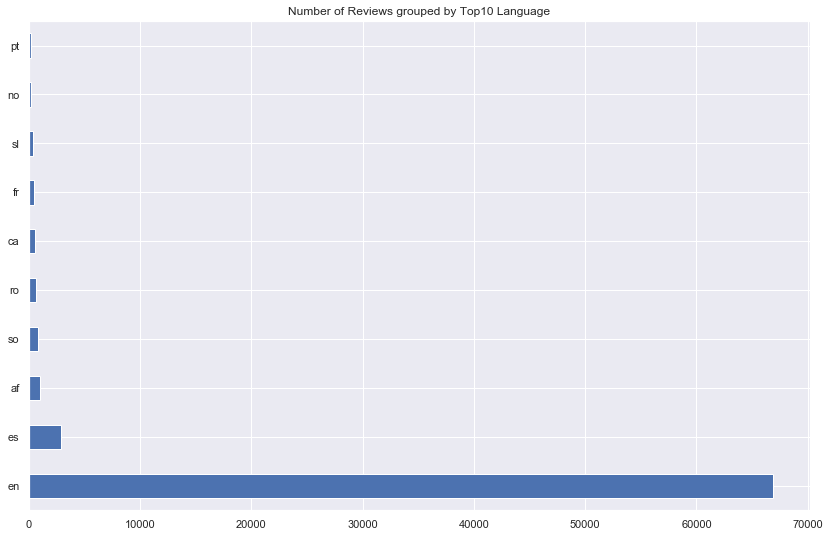

In [30]:
from langdetect import detect
def lang_detect(text):
    try:
        return detect(text)
    except:
        return None
import time
start_time = time.time()
final_product_reviews["lang"] = final_product_reviews["body"].apply(lang_detect)
print("It takes %s seconds for the code to finish." % (time.time() - start_time))
# 1.2 Plot distribution of reviews into languages
final_product_reviews["lang"].value_counts()[:10].plot(kind="barh", title="Number of Reviews grouped by Top10 Language")
plt.show()


In [31]:
analyzer = SentimentIntensityAnalyzer()

In [32]:
final_product_reviews["body"] = final_product_reviews["body"].astype("str")
final_product_reviews["sent_neg"] = final_product_reviews["body"].apply(lambda x: analyzer.polarity_scores(x)["neg"])
final_product_reviews["sent_neu"] = final_product_reviews["body"].apply(lambda x: analyzer.polarity_scores(x)["neu"])
final_product_reviews["sent_pos"] = final_product_reviews["body"].apply(lambda x: analyzer.polarity_scores(x)["pos"])
final_product_reviews["sent_comp"] = final_product_reviews["body"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

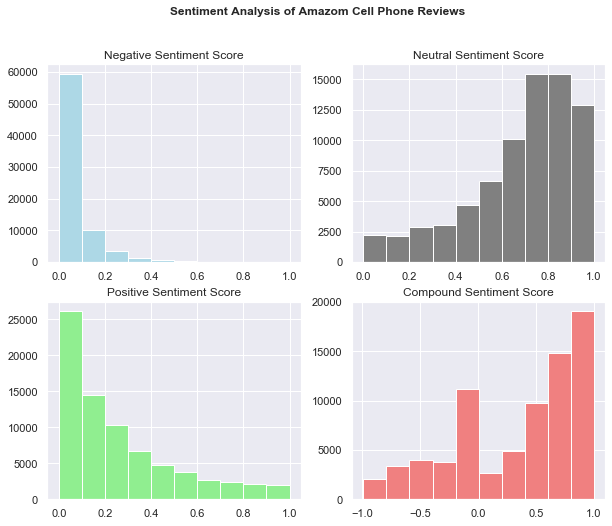

In [33]:
plt.subplot(2, 2, 1)
final_product_reviews["sent_neg"].hist(figsize=(10, 8), color="lightblue")
plt.title("Negative Sentiment Score")
plt.subplot(2, 2, 2)
final_product_reviews["sent_neu"].hist(figsize=(10, 8), color="grey")
plt.title("Neutral Sentiment Score")
plt.subplot(2, 2, 3)
final_product_reviews["sent_pos"].hist(figsize=(10, 8), color="lightgreen")
plt.title("Positive Sentiment Score")
plt.subplot(2, 2, 4)
final_product_reviews["sent_comp"].hist(figsize=(10, 8), color="lightcoral")
plt.title("Compound Sentiment Score")

plt.suptitle('Sentiment Analysis of Amazom Cell Phone Reviews', fontsize=12, fontweight='bold');

plt.show()

In [34]:
final_product_reviews.head()

,asin,brand,title,rating,totalReviews,prices,overall_rating,date,verified,product_title,body,helpfulVotes,positivity,clean_text,lang,sent_neg,sent_neu,sent_pos,sent_comp
14,B0009N5L7K,Motorola,Motorola I265 phone,2.9,7,$49.95,1,"March 5, 2016",True,Stupid phone,DON'T BUY OUT OF SERVICE,NaN,-1,buy service,de,0.000,1.000,0.000,0.0000
17,B0009N5L7K,Motorola,Motorola I265 phone,2.9,7,$49.95,1,"December 20, 2016",True,Phones locked,1 star because the phones locked so I have to ...,NaN,-1,1 star phone lock pay additional fee unlock,en,0.113,0.887,0.000,-0.1689
18,B0009N5L7K,Motorola,Motorola I265 phone,2.9,7,$49.95,5,"December 13, 2009",True,Excellent product,The product has been very good. I had used thi...,NaN,1,product good use cell one project work wonder ...,en,0.000,0.701,0.299,0.8777
21,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,2.6,22,NaN,4,"September 17, 2010",True,"Nice, but",I bought this phone to replace an LG phone tha...,NaN,1,buy replace lg like expect put old sim card ne...,en,0.058,0.808,0.134,0.9389
22,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,2.6,22,NaN,1,"May 13, 2017",True,It seems it doesn't work with the existing AT&...,I purchased this phone for my AT&T phone repla...,NaN,-1,purchase replacement even though one faq menti...,en,0.000,1.000,0.000,0.0000


The correlation coefficient between sentiment score (compound) and rating is  0.5746 with a p-value of  0.0000.


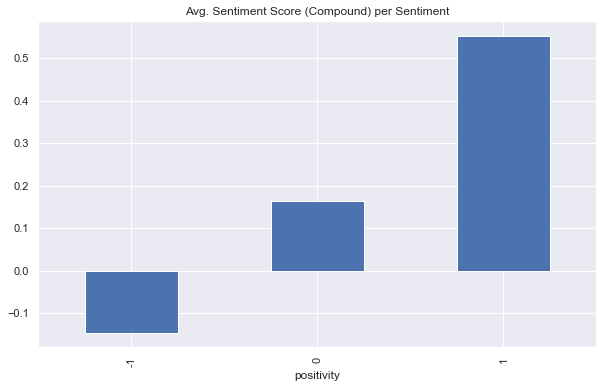

In [35]:
import scipy.stats as stats
print("The correlation coefficient between sentiment score (compound) and rating is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(final_product_reviews["positivity"], final_product_reviews["sent_comp"])))
final_product_reviews.groupby("positivity").mean()["sent_comp"].plot(kind="bar", figsize=(10, 6))
plt.title("Avg. Sentiment Score (Compound) per Sentiment")
plt.show()

## Modelling Naive Bayes

In [36]:
data=final_product_reviews['clean_text']
rating_target=final_product_reviews['overall_rating']
positivity_target=final_product_reviews['positivity']

### Data Split and Preparation for Model

In [40]:
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=0.0, stop_words="english")

rat_train,rat_test,rat_train_target,rat_test_target=train_test_split(data,rating_target,test_size=0.2)
pos_train,pos_test,pos_train_target,pos_test_target=train_test_split(data,positivity_target,test_size=0.2)

rat_train_data=tfidf_vectorizer.fit_transform(rat_train)
rat_test_data=tfidf_vectorizer.transform(rat_test)

pos_train_data=tfidf_vectorizer.fit_transform(pos_train)
pos_test_data=tfidf_vectorizer.transform(pos_test)

### Model Naive Bayes on Target Rating

Model on Ratings performance
Accuracy= 0.672005294506949
Evaluation:
              precision    recall  f1-score   support

           1       0.73      0.62      0.67      2985
           2       0.00      0.00      0.00       778
           3       0.00      0.00      0.00      1019
           4       0.40      0.00      0.00      1956
           5       0.66      0.99      0.79      8372

    accuracy                           0.67     15110
   macro avg       0.36      0.32      0.29     15110
weighted avg       0.56      0.67      0.57     15110

[[1846    0    0    1 1138]
 [ 311    0    0    2  465]
 [ 209    0    0    0  810]
 [  81    0    0    2 1873]
 [  66    0    0    0 8306]]


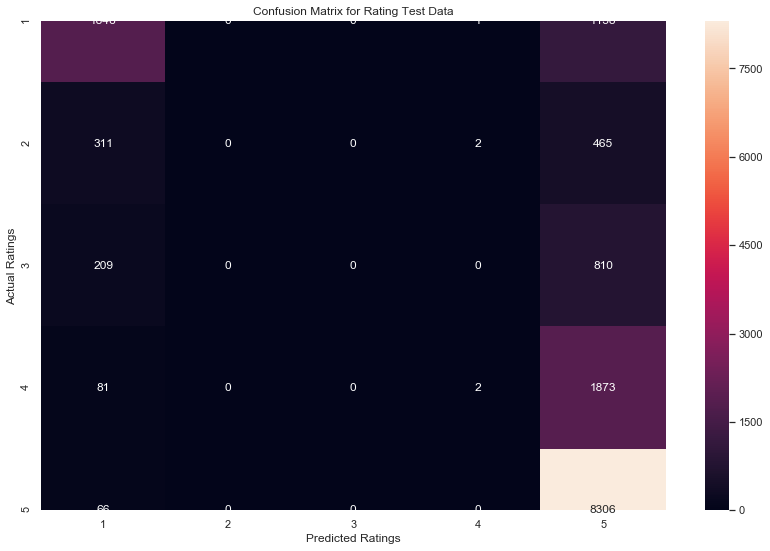

In [43]:
rat_multi_class=MultinomialNB()
rat_multi_class.fit(rat_train_data,rat_train_target)
rat_output=rat_multi_class.predict(rat_test_data)
print('\033[1;4m'+'Model on Ratings performance'+'\033[0m')
print('Accuracy=',accuracy_score(rat_output,rat_test_target))
print('Evaluation:')
print(classification_report(rat_test_target,rat_output))

rat_cnf_matrix=confusion_matrix(rat_test_target,rat_output,labels=[1,2,3,4,5])
print(rat_cnf_matrix)
plt.clf()
plt.title('Confusion Matrix for Rating Test Data')
ax=plt.axes()
ht=sns.heatmap(pd.DataFrame(rat_cnf_matrix),annot=True,fmt='g',xticklabels=[1,2,3,4,5],yticklabels=[1,2,3,4,5],ax=ax)
ax.set(ylabel='Actual Ratings',xlabel='Predicted Ratings')
fig=ht.get_figure()
fig.savefig('Ratings Confusion Matrix.png')

### Model Naive Bayes on Target Positivity

Model on Sentiment performance
Accuracy= 0.8168762409000662
Evaluation:
              precision    recall  f1-score   support

          -1       0.85      0.57      0.68      3713
           0       0.00      0.00      0.00      1018
           1       0.81      0.98      0.89     10379

    accuracy                           0.82     15110
   macro avg       0.55      0.52      0.52     15110
weighted avg       0.77      0.82      0.78     15110

[[ 2125     0  1588]
 [  209     0   809]
 [  161     0 10218]]


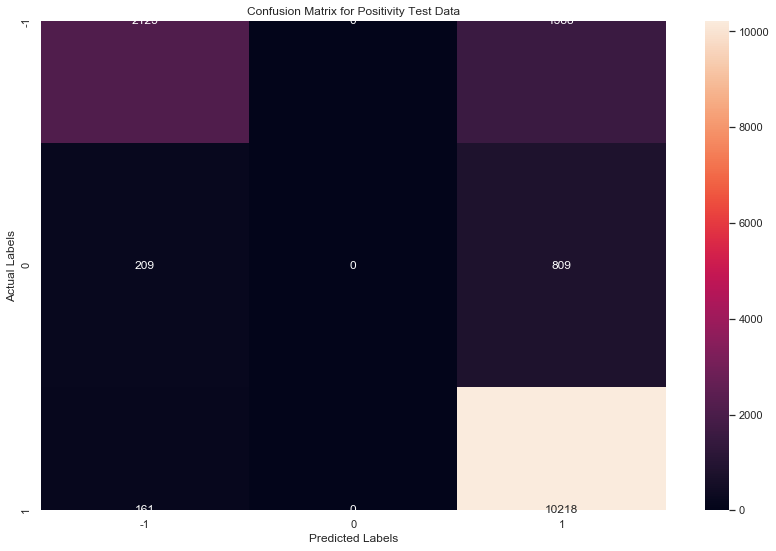

In [46]:
pos_multi_class=MultinomialNB()
pos_multi_class.fit(pos_train_data,pos_train_target)
pos_output=pos_multi_class.predict(pos_test_data)
print('\033[1;4m'+'Model on Sentiment performance'+'\033[0m')
print('Accuracy=',accuracy_score(pos_output,pos_test_target))
print('Evaluation:')
print(classification_report(pos_test_target,pos_output))

pos_cnf_matrix=confusion_matrix(pos_test_target,pos_output,labels=[-1,0,1])
print(pos_cnf_matrix)
plt.clf()
plt.title('Confusion Matrix for Positivity Test Data')
ax=plt.axes()
ht=sns.heatmap(pd.DataFrame(pos_cnf_matrix),annot=True,fmt='g',xticklabels=[-1,0,1],yticklabels=[-1,0,1],ax=ax)
ax.set(ylabel='Actual Labels',xlabel='Predicted Labels')
fig=ht.get_figure()
fig.savefig('Positivity Confusion Matrix.png')